### Antonio Gagliardo | Recipe Sentiment Analysis and Recommendation System

# Index


## [Section 1: Exploring and Cleaning](#Section1)
## [Section 2: User-item Matrix](#Section2)
## [Section 3: Similarity Calculation](#Section3)
## [Section 4: Recommendation Generation](#Section4)
## [Section 5: Conclusion](#Section5)


------------------
-----------------

## Intro

This project aimed to develop a collaborative food recommender system based user reviews. The project involved collecting user reviews, building a user-item matrix, calculating user similarities, and predicting ratings for recipes. At the end I will put all together in a  function to give recommendation based on similar users.

This approach helps users discover new recipes tailored to their tastes, enhancing user experience and satisfaction with the recommendation system.
 
### Data
The data was taken from Kaggle and is a dataset from Food.com credit to the person who created the dataset: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews

or you can use my **drive link** to download the dataset: https://drive.google.com/drive/folders/17rwRC48Lk1K36z6mU6M3t6ePOsDz51fR


# Section1 
## Exploring and Cleaning

First I import some of the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Loading the data:

In [2]:
rev = pd.read_csv('foodcom_with_reviews/reviews.csv')

Previewing the DataFrame

In [3]:
rev.head(3)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z


Exploring the DataFrame to know more about it

In [4]:
rev.columns

Index(['ReviewId', 'RecipeId', 'AuthorId', 'AuthorName', 'Rating', 'Review',
       'DateSubmitted', 'DateModified'],
      dtype='object')

In [5]:
rev.dtypes

ReviewId          int64
RecipeId          int64
AuthorId          int64
AuthorName       object
Rating            int64
Review           object
DateSubmitted    object
DateModified     object
dtype: object

In [6]:
rev['AuthorId'].value_counts()

424680        8842
37449         6605
383346        5438
128473        4693
169430        4586
              ... 
1701969          1
1585419          1
1704446          1
1417548          1
2002812127       1
Name: AuthorId, Length: 271907, dtype: int64

In [7]:
author_reviews = rev.groupby('AuthorId')['ReviewId'].count()
author_reviews

AuthorId
1533           153
1535          1044
1566             1
1581             2
1634            79
              ... 
2002901749       1
2002901759       1
2002901787       1
2002901848       1
2002901938       1
Name: ReviewId, Length: 271907, dtype: int64

In [8]:
author_reviews.value_counts().sort_index()

1       199808
2        27067
3        11243
4         6106
5         4114
         ...  
4586         1
4693         1
5438         1
6605         1
8842         1
Name: ReviewId, Length: 699, dtype: int64

In [9]:
rev_less_10 = rev['AuthorId'].value_counts()<10
rev_less_10

424680        False
37449         False
383346        False
128473        False
169430        False
              ...  
1701969        True
1585419        True
1704446        True
1417548        True
2002812127     True
Name: AuthorId, Length: 271907, dtype: bool

### Selecting
Bellow I will be checking how the data will look if i take all the reviewers, or if i take only reviewers that did more than 10, 20, 50 reviews.

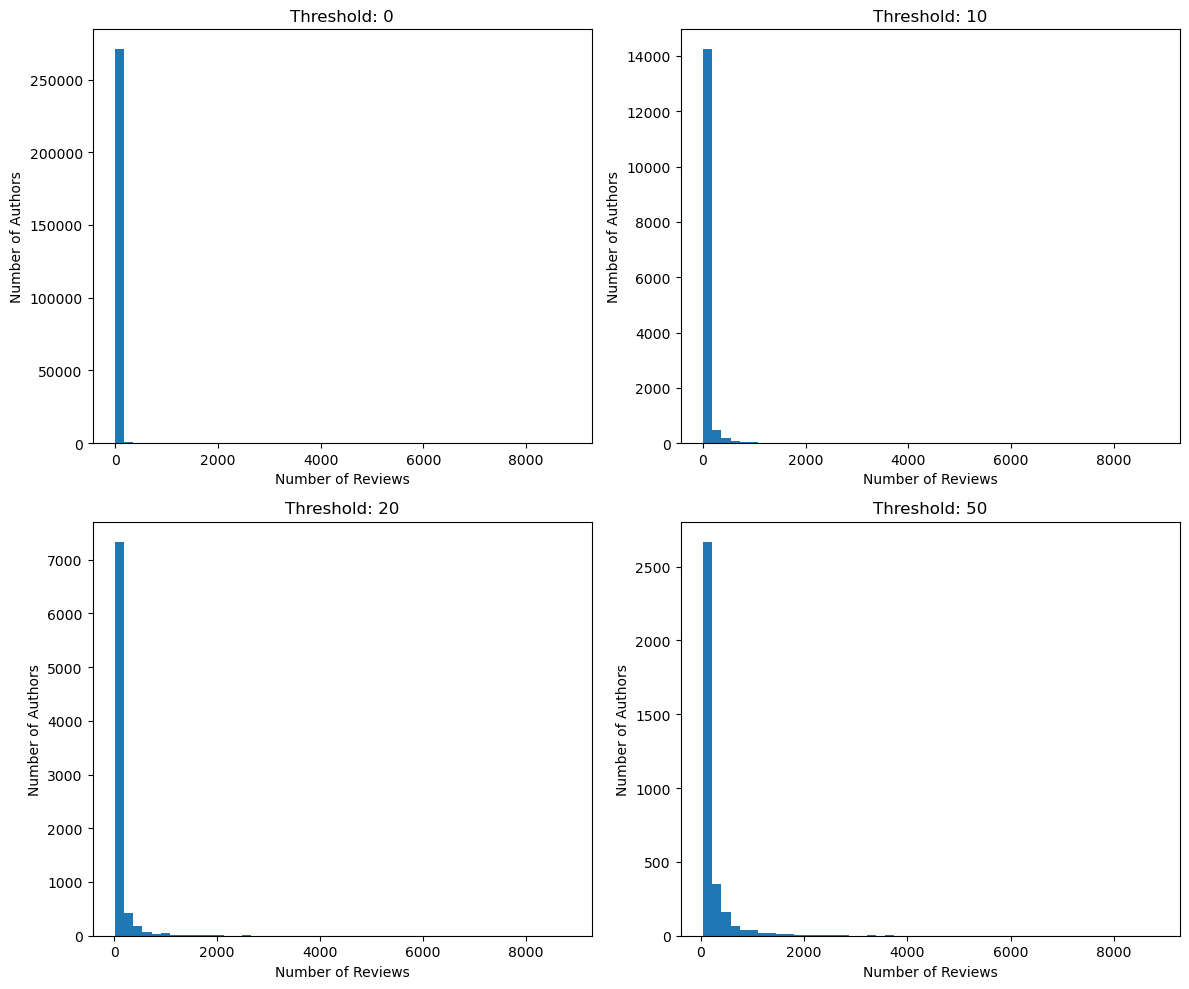

In [10]:

# Group the DataFrame by AuthorId and count the number of reviews per author
review_counts = rev['AuthorId'].value_counts()

# Define the thresholds
thresholds = [0, 10, 20, 50]

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot histograms for different thresholds
for i, threshold in enumerate(thresholds):
    # Filter authors based on the threshold
    filtered_authors = review_counts[review_counts >= threshold]

    # Plotting the histogram on the corresponding subplot
    ax = axs[i // 2][i % 2]
    filtered_authors.plot(kind='hist', bins=50, ax=ax)

    # Set the labels and title of each subplot
    ax.set_xlabel('Number of Reviews')
    ax.set_ylabel('Number of Authors')
    ax.set_title(f'Threshold: {threshold}')

# Adjust the spacing between subplots
fig.tight_layout()

# Display the chart
plt.show()

# this subplot code was done with the help of chat gpt

Since the Data is huge I have to cut it either way, so the best thing is start thinking what data would be better to get rid of. In this case, the best thing would be getting rid of users that have reviews less than X amount of times, since it would make difficult to test my data if my sample ends up being full of users that have never rated.

In [11]:
rev_less_10.value_counts()

True     256734
False     15173
Name: AuthorId, dtype: int64

With this info I know that at least 15,000 users have rated more than 10 recipes, which then 10 its an ok number to work with.

Still I will explore with other values to see which one I could choose.

In [12]:
thresholds = [0, 10, 20, 50]
for i in thresholds:
    filtered_users = rev['AuthorId'].value_counts() >= i
    num_filtered_users = sum(filtered_users)
    print(f"The number of users who rated more than {i} recipes is: {num_filtered_users}")


The number of users who rated more than 0 recipes is: 271907
The number of users who rated more than 10 recipes is: 15173
The number of users who rated more than 20 recipes is: 8213
The number of users who rated more than 50 recipes is: 3427


In [13]:
# Groups by AuthorId and count the number of occurrences per author
user_counts = rev['AuthorId'].value_counts()

# Filter out users with less than 50 occurrences
filtered_users = user_counts[user_counts >= 50]

# Count the number of filtered users
num_filtered_users = len(filtered_users)

# Print the result
print("Number of users with at least 50 occurrences:", num_filtered_users)


Number of users with at least 50 occurrences: 3427


Cheking the shape before reducing my dataset

In [14]:
rev['AuthorId'].value_counts()

424680        8842
37449         6605
383346        5438
128473        4693
169430        4586
              ... 
1701969          1
1585419          1
1704446          1
1417548          1
2002812127       1
Name: AuthorId, Length: 271907, dtype: int64

In [15]:
rev.shape

(1401982, 8)

Reducing my dataset to users with only users that have done at least 50 reviews.

In [16]:

# Group by AuthorId and count the number of occurrences per author
user_counts = rev['AuthorId'].value_counts()

# Filter out users with less than 50 occurrences
filtered_users = user_counts[user_counts >= 50]

# Filter the  DataFrame based on the filtered users
rev = rev[rev['AuthorId'].isin(filtered_users.index)]



In [17]:
rev['AuthorId'].value_counts()

424680    8842
37449     6605
383346    5438
128473    4693
169430    4586
          ... 
381538      50
346812      50
371350      50
416537      50
38901       50
Name: AuthorId, Length: 3427, dtype: int64

As it can be seen it worked, and the dataset is still huge (more than 750,000  rows still)

In [18]:
rev.shape

(769042, 8)

For speed purposes I still need to decrease the dataset, so instead of randomly sample right away, another criteria that would make it easier to test and try my models is getting rid of recipes that don't have many ratings. So the code above will take care of that.

In [19]:

# Group  by AuthorId and count the number of occurrences per author
recipe_counts = rev['RecipeId'].value_counts()

# Filter out users with less than 10 occurrences
filtered_recipes = recipe_counts[recipe_counts >= 10]

# Filter the  DataFrame based on the filtered users
rev = rev[rev['RecipeId'].isin(filtered_recipes.index)]
rev.head(3)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
159,243,810,2312,Gay Gilmore,0,"Good, but I wished they were a bit more moist.",2001-01-02T16:15:26Z,2001-01-02T16:15:26Z
366,526,8600,2312,Gay Gilmore,4,"Fancy macaroni and cheese, so you don't have t...",2001-03-13T19:51:36Z,2001-03-13T19:51:36Z
485,700,2886,2312,Gay Gilmore,5,I used one more banana than called for because...,2001-04-18T08:53:27Z,2001-04-18T08:53:27Z


In [20]:
rev['RecipeId'].value_counts()

45809     708
27208     489
89204     433
39087     371
32204     371
         ... 
71245      10
278421     10
71257      10
281851     10
517410     10
Name: RecipeId, Length: 13261, dtype: int64

In [21]:
rev.shape

(294260, 8)

Gladly in terms of reviews, it means that I still have a bit more than 294,000 reviews.

In [22]:
rev.head(3)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
159,243,810,2312,Gay Gilmore,0,"Good, but I wished they were a bit more moist.",2001-01-02T16:15:26Z,2001-01-02T16:15:26Z
366,526,8600,2312,Gay Gilmore,4,"Fancy macaroni and cheese, so you don't have t...",2001-03-13T19:51:36Z,2001-03-13T19:51:36Z
485,700,2886,2312,Gay Gilmore,5,I used one more banana than called for because...,2001-04-18T08:53:27Z,2001-04-18T08:53:27Z


In [23]:
print(sum(rev['AuthorId'].value_counts()<50))

1656


I also have more than 1600 different Authors (of reviews)

In [24]:
rev.isna().sum()

ReviewId         0
RecipeId         0
AuthorId         0
AuthorName       0
Rating           0
Review           1
DateSubmitted    0
DateModified     0
dtype: int64

In [25]:
rev.dropna(inplace = True)

In [26]:
rev.isna().sum()

ReviewId         0
RecipeId         0
AuthorId         0
AuthorName       0
Rating           0
Review           0
DateSubmitted    0
DateModified     0
dtype: int64

In [27]:
rev.isna().sum()

ReviewId         0
RecipeId         0
AuthorId         0
AuthorName       0
Rating           0
Review           0
DateSubmitted    0
DateModified     0
dtype: int64

In [28]:
rev.duplicated().sum()

0

There is no duplicates. Now just doble checking the shape of my DataFram

In [29]:
rev.shape

(294259, 8)

In [30]:
rev_n_users = rev['AuthorId'].nunique()
rev_n_reviews = rev.shape[0]
print(f'There are {rev_n_users} user that reviews {rev_n_reviews} times in total in my final dataset')

There are 3424 user that reviews 294259 times in total in my final dataset


The code below is the one I was using for sampling. In summary, if I choose a sample higher than the current dataset, it just picks the dataset. If my sample is lower, it takes the sample. I used this a lot to play aorund with different thresholds and to see what my computer can handle, and this came to be the best size for my case.

In [31]:
rev_sample_size = 300000


# Check if the dataset has more rows than the sample 
if len(rev) > rev_sample_size:
    # Take a random sample 
    sample_rev = rev.sample(n=rev_sample_size, random_state=1) 
else:
    # this is in case i set the sample to a number higher than the dataset
    sample_rev = rev

In this specific case since the dataset is 294,000 I will take all of them.

In [32]:
sample_rev.shape

(294259, 8)

In [33]:
sample_rev['AuthorId'].nunique()

3424

In [34]:
sample_rev.head(3)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
159,243,810,2312,Gay Gilmore,0,"Good, but I wished they were a bit more moist.",2001-01-02T16:15:26Z,2001-01-02T16:15:26Z
366,526,8600,2312,Gay Gilmore,4,"Fancy macaroni and cheese, so you don't have t...",2001-03-13T19:51:36Z,2001-03-13T19:51:36Z
485,700,2886,2312,Gay Gilmore,5,I used one more banana than called for because...,2001-04-18T08:53:27Z,2001-04-18T08:53:27Z


# Section2
## User-item Matrix

I reset the index, now I will reset the Author ids and Recipe Id to make it easier for me and the machine

In [35]:
sample_rev.reset_index(drop=True, inplace=True)

In [36]:
sample_rev.head(3)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,243,810,2312,Gay Gilmore,0,"Good, but I wished they were a bit more moist.",2001-01-02T16:15:26Z,2001-01-02T16:15:26Z
1,526,8600,2312,Gay Gilmore,4,"Fancy macaroni and cheese, so you don't have t...",2001-03-13T19:51:36Z,2001-03-13T19:51:36Z
2,700,2886,2312,Gay Gilmore,5,I used one more banana than called for because...,2001-04-18T08:53:27Z,2001-04-18T08:53:27Z


Just checking a few things out o my data:

In [37]:
sample_rev['AuthorId'].max()

2002754832

In [38]:
sample_rev['RecipeId'].max()

517594

In [39]:
sample_rev.head(3)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,243,810,2312,Gay Gilmore,0,"Good, but I wished they were a bit more moist.",2001-01-02T16:15:26Z,2001-01-02T16:15:26Z
1,526,8600,2312,Gay Gilmore,4,"Fancy macaroni and cheese, so you don't have t...",2001-03-13T19:51:36Z,2001-03-13T19:51:36Z
2,700,2886,2312,Gay Gilmore,5,I used one more banana than called for because...,2001-04-18T08:53:27Z,2001-04-18T08:53:27Z


In [40]:
sample_rev['AuthorId'].max()

2002754832

doing a reduced version of my DataFrame with the columns I will need to make the collaborative based recommendation system.

In [41]:
sample_rev_core = sample_rev[['RecipeId', 'AuthorId', 'Rating']]
sample_rev_core = sample_rev_core.sort_values(by='AuthorId', key=lambda x: x.map(x.value_counts()), ascending = False)
sample_rev_core.head(5)

,RecipeId,AuthorId,Rating
266147,89925,140132,5
184920,11168,140132,4
286428,52087,140132,5
184921,41169,140132,5
184922,42603,140132,4


In [42]:
for column in sample_rev_core.columns:
    print(f'{column} max number is: {sample_rev_core[column].max()}')

RecipeId max number is: 517594
AuthorId max number is: 2002754832
Rating max number is: 5


Doing a small prototype of what will be my code.

In [43]:
users = sample_rev_core['AuthorId'].unique()
rec = sample_rev_core['RecipeId'].unique()

num_users = len(users)
num_recipes = len(rec)
           
# np.nan means they user has not reviewed the movie
R = np.full((num_users, num_recipes), np.nan)
R

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [44]:
R.shape

(3424, 13261)

The code below does an user-item matrix from the 'sample_rev_core' dataset for a food recommender system. It extracts unique users and recipes, initializes the matrix with NaN values, and fills the matrix  with ratings. Finally, it creates a DataFrame representation of the matrix.

In [45]:
users = sample_rev_core['AuthorId'].unique()
rec = sample_rev_core['RecipeId'].unique()

num_users = len(users)
num_recipes = len(rec)

# np.nan means the user has not reviewed the recipe
R = np.full((num_users, num_recipes), np.nan)

# Build the user-item matrix
for row in sample_rev_core.itertuples():
    user = np.where(users == row.AuthorId)[0][0]  
    recipe = np.where(rec == row.RecipeId)[0][0] 
    rating = row.Rating
    R[user, recipe] = rating

R_df = pd.DataFrame(data=R, index=users, columns=rec)


In [46]:
list(sample_rev_core.itertuples())[0]

Pandas(Index=266147, RecipeId=89925, AuthorId=140132, Rating=5)

Just searching a few recipes to see how my data looks like, and will use some of these numbers to test my code later on (recipes and users, to see if they appear in common and see if my recommender is working effectively).

In [47]:
sample_rev_core[sample_rev_core['RecipeId']== 53496]

,RecipeId,AuthorId,Rating
248618,53496,280271,4
188941,53496,486725,5
79955,53496,68460,5
151388,53496,285039,5
39078,53496,173314,5
8595,53496,46660,5
273947,53496,315055,3
224809,53496,143318,5
9586,53496,8606,5
78814,53496,148316,4


In [48]:
sample_rev_core[sample_rev_core['RecipeId']== 67781]

,RecipeId,AuthorId,Rating
231123,67781,140132,5
183919,67781,158086,5
181217,67781,1072593,5
71821,67781,145352,5
98811,67781,394077,5
...,...,...,...
158736,67781,346383,5
41035,67781,147095,5
79959,67781,78682,5
263659,67781,145448,5


Below I will finally print the R dataframe that I did before, which shows all the users and recipes.

In [49]:
R_df

,89925,11168,52087,41169,42603,11595,137562,46267,53692,81764,...,48000,40383,46543,34398,260375,261418,220348,261718,261683,38883
140132,5.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
383346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176615,NaN,NaN,NaN,5.0,5.0,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
487279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1169937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1806667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Section3
## Similarity Calculation

The code below selects a user, retrieves their ratings from the matrix that I did before, finds common recipes with other users, identifies similar users who have rated at least 5 common recipes, excludes the given user, and prints the list of similar users for potential recommendations. 

In [50]:


# Select the desired user ID
given_user_id = 288351

# Get the ratings for the given user
given_user_ratings = R_df.loc[given_user_id, :]

# Find the common recipes between the given user and other users
common_recipes = R_df.columns[given_user_ratings.notna()]

# Find users who have rated the common recipes
similar_users = R_df[R_df[common_recipes].notna().sum(axis=1) >= 5].index

# Exclude the given user from the similar users list
similar_users = similar_users[similar_users != given_user_id]

print("Similar users who have rated at least 5 common items with User", given_user_id, ":")
print(similar_users)

# This code was done with help of chat gpt


Similar users who have rated at least 5 common items with User 288351 :
Int64Index([ 140132,   37449,  383346,  176615,  126440,  128473,   89831,
             226863,  173579,  133174,
            ...
             427101,  763856,  247241, 1330315,  899120,  950577,  651269,
             350910,  518275,   75726],
           dtype='int64', length=725)


The code above was very useful to help me test the next codes, since there are so many recipes and users that most of the time by picking at random, users had no rated recipes in common (or just 1 or 2).

The code below tells how many recipes (in common) both users rated.

In [51]:
recipes_1st_user_rated = ~R_df.loc[288351, :].isna()
recipes_2nd_user_rated = ~R_df.loc[91867, :].isna()

recipes_both_users_rated = recipes_1st_user_rated & recipes_2nd_user_rated
print(recipes_both_users_rated.sum())

8


Finally, if gives me a matrix showing and comparing all the recipes they both rated and what score they gave them.

In [52]:
print("Reviewers' scores:")
R_df.loc[[288351, 91867], recipes_both_users_rated]

Reviewers' scores:


,15072,22782,64138,4957,35813,79116,32614,22176
288351,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
91867,5.0,4.0,5.0,5.0,5.0,5.0,4.0,5.0


In [53]:
from sklearn.metrics.pairwise import cosine_similarity 

C:\Users\ajgag\anaconda3\envs\capstone2\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Now I will search how similar this 2 users are with cosine_similarity.

In [54]:
print("Similarity:", cosine_similarity(R_df.loc[288351, recipes_both_users_rated].values.reshape(1,-1), 
                                       R_df.loc[91867, recipes_both_users_rated].values.reshape(1,-1)))

Similarity: [[0.99587059]]


# Section4 
## Recommendation Generation

The similarity is amazingly good, its normal since they rated everything almost the same, there are jus 2 recipes that they rated different but both of them gave a high score to it.

After doing it manually, here is a function that will automate it, to make it in a single step:

In [55]:
def find_user_similarity(user_1, user_2, R_df):
    
    # Define the mask which finds all recipes they rated together
    recipes_1st_user_rated = ~R_df.loc[user_1, :].isna()
    recipes_2nd_user_rated = ~R_df.loc[user_2, :].isna()

    recipes_both_users_rated = recipes_1st_user_rated & recipes_2nd_user_rated
    
    if recipes_both_users_rated.sum() == 0:
         return 0, 0

    # Sum boolean to get the counts
    number_of_recipes_rated_together = recipes_both_users_rated.sum()
        
    # Finding the ratings of both users for recipes they both reated
    ratings_of_user1 = R_df.loc[user_1, recipes_both_users_rated].values.reshape(1, -1)
    ratings_of_user2 = R_df.loc[user_2, recipes_both_users_rated].values.reshape(1, -1)
    
    # Finally, calculate the similarity between them
    similarity = cosine_similarity(ratings_of_user1, ratings_of_user2)[0][0]
    
    return similarity, number_of_recipes_rated_together

In [56]:
find_user_similarity(288351, 91867, R_df)

(0.9958705948858223, 8)

And there we have the same similarity~

The next I will load the recipe dataset so I an also have recipe and author names and not only work with ids

In [57]:
recipe = pd.read_csv('foodcom_with_reviews/recipes.csv')
recipe.head(2)

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."


The next few block of codes would just be me testing how to get the RecipeId -> 'Name' of the recipe , and the same with AuthorId -> 'AuthorName' and also giving them a variable so it can work with any recipe name and author name.

In [58]:
current_user = 126440
current_recipe = 89925

In [59]:
recipe_name = recipe.loc[recipe['RecipeId'] == current_recipe, 'Name']
recipe_name

84763    Popeye's Fried Chicken Copycat
Name: Name, dtype: object

In [60]:
print(recipe_name)

84763    Popeye's Fried Chicken Copycat
Name: Name, dtype: object


In [61]:
type(recipe_name)

pandas.core.series.Series

In [62]:
recipe_name_str = recipe_name.item()

In [63]:
recipe_name_str

"Popeye's Fried Chicken Copycat"

In [64]:
username000 = recipe.loc[recipe['AuthorId'] == current_user, 'AuthorName'].head(1)
username000

95963    adopt a greyhound
Name: AuthorName, dtype: object

In [65]:
username001 = username000.item()
username001

'adopt a greyhound'

Finally a function that incorporates everything I did before. The predict_rating function takes a current user and recipe, along with a user-item matrix (R_df) and recipe DataFrame. It predicts the rating based on similarities to other users, returns the predicted rating, recipe id & name, and user id & name.

In [66]:
# now I put everything together on a function and this is what came out:

def predict_rating(current_user, current_recipe, R_df, recipe):
    similarities_to_user = []
    ratings_given_to_recipe = []

    # Find only the users who rated the current recipe (rows)
    R_df_recipe = R_df[~R_df[current_recipe].isna()].copy()

    for other_user in R_df_recipe.index:
        similarity, number_of_recipes_rated_together = find_user_similarity(current_user, other_user, R_df)
        similarities_to_user.append(similarity)
        ratings_given_to_recipe.append(R_df.loc[other_user, current_recipe])

    # Convert to numpy arrays
    similarities_to_user = np.array(similarities_to_user)
    ratings_given_to_recipe = np.array(ratings_given_to_recipe)

    predicted_rating = np.dot(ratings_given_to_recipe, similarities_to_user) / np.sum(similarities_to_user)
    recipe_name = recipe.loc[recipe['RecipeId'] == current_recipe, 'Name'].item()
    username = recipe.loc[recipe['AuthorId'] == current_user, 'AuthorName'].head(1).item()

    return predicted_rating, recipe_name, username





In [67]:
#testing the function
current_user = 91867
current_recipe = 45809

predicted_rating, recipe_name, username = predict_rating(current_user, current_recipe, R_df, recipe)
print(f"Predicted rating for recipe {current_recipe} ({recipe_name}) by user {current_user} ({username}) is {round(predicted_rating, 2)}")


Predicted rating for recipe 45809 (Bourbon Chicken) by user 91867 (The Giggle Box) is 4.55


In [68]:
#testing the function
current_user = 126440
current_recipe = 89925

predicted_rating, recipe_name, username = predict_rating(current_user, current_recipe, R_df, recipe)
print(f"Predicted rating for recipe {current_recipe} ({recipe_name}) by user {current_user} ({username}) is {round(predicted_rating, 2)}")


Predicted rating for recipe 89925 (Popeye's Fried Chicken Copycat) by user 126440 (adopt a greyhound) is 3.71


Tested it twice, and it works!

#
## Conclusion

In conclusion, this project implemented a collaborative based recommender system for predicting ratings of recipes. The `predict_rating` function utilized user similarities and ratings given to the recipe by other users to estimate the rating that the current user would provide. The system considered the recipe name and the username to provide personalized recommendations. By using user reviews, the project successfully generated predictions and can serve as a basis for building a practical food recommendation system, either for personal use or commercial use.